# Introduction

Putative Creode or p-Creode is an algorithm developed to map transitions between states. Particularly, p-Creode was developed to map multi-branched cellular differentiation pathways using single cell data. This notebook will give an overview of applying p-Creode to a single cell RNA-seq data set produced by [Paul et al., 2015](http://www.sciencedirect.com/science/article/pii/S0092867415014932).

Before getting started, if you are not familar with juypter notebooks, some basic information can be found [here](http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb) This notebook is designed to walk you through a common p-Creode application, so each notebook cell with python code in it should be excuted as you procede. Notebook cells can be executed by simply pressing shift+enter. Please report any issues or bugs you come across to the p-Creode github page. 

Please note that this tutorial utilizes Scanpy. Which was described by [Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0). Scanpy is a python package for the organization and analysis of large scale scRNA-seq data. Scanpy documentation is available [here](https://scanpy.readthedocs.io/en/stable/).

# Importing python modules and loading data

Before a python module or package can be accessed it has to be imported. Here the p-Creode package along with other common python packages for handling data sets and plotting are imported. All of these packages should have been installed when pcreode was installed. If any of the packages are not installed, pip install package should remedy the situation (for example: “pip install numpy” or if administrative privileges are needed for linux users “sudo pip install numpy”).

In [1]:
import scanpy as sc #import scanpy
import pandas as pd #pandas 
import numpy as np #import numpy
 #import pcreode
import matplotlib.pylab as plt #import matplotlib 
from sklearn.cluster import KMeans #import the KMeans algorithm from scikit-learn
import pcreode.pcreode as pcreode
import pcreode.functions as pcreode_functions

In [2]:
sc.set_figure_params(dpi=80) #set figure display size

This myeloid differentiation dataset consists of 4423 cells with 14955 features each in its entirety, and is stored as a compressed .h5ad file format, which is compatible with the Scanpy python package, a single-cell analysis framework. In utilizing the AnnData data structure, we gain access some of Scanpy's preprocessing, read/write, and plotting tools. 

In [3]:
myeloid_adata = sc.read_h5ad("../data/Myeloid_Raw_Normalized_Transformed.h5ad")
myeloid_adata

AnnData object with n_obs × n_vars = 4423 × 14955

# Preprocessing

### Unsupervised feature selection

Before we move into the main pCreode analysis, we must first consider that scRNA-seq has an inherent degree of noise originating from stochastic gene expression as well as the technical limitations of the process. So, even though assays may detect the expression of tens of thousands of genes, only a fraction of those genes present robust, biologically meaningful signals. To select these genes, we utilize an unsupervised feature selection method called highly_variable_genes, described by Satija et al., 2015 and implemented in Scanpy. 

Here, a minimum scaled dispersion of 0 and a minimum scaled mean of 0.1 are selected to capture medium-to-high dispersion and expression genes respectively. 

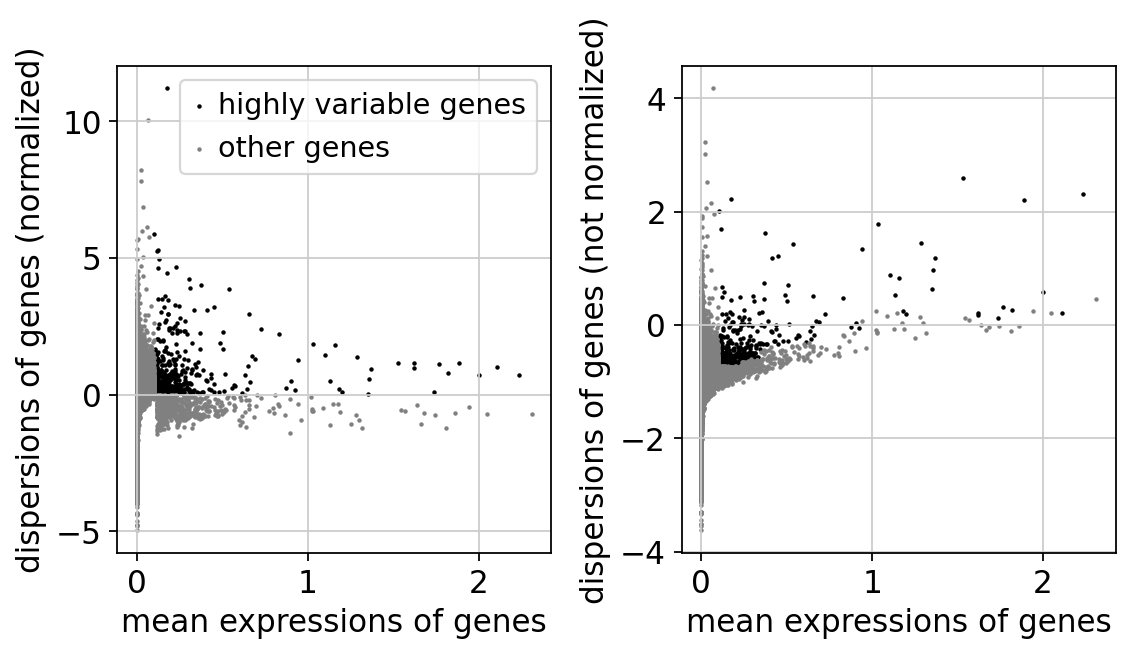

In [4]:
sc.pp.highly_variable_genes(myeloid_adata,min_mean=0.1,min_disp=0,flavor='seurat')
sc.pl.highly_variable_genes(myeloid_adata)

In [5]:
myeloid_adata.var.index[np.where(myeloid_adata.var['highly_variable'])[0]]

Index(['0610012G03RIK', '0910001L09RIK', 'MIR1892', 'MCMBP', 'RPL36AL',
       '1110038B12RIK', '1190002H23RIK', '1500011K16RIK', '1500012F01RIK',
       '1810009A15RIK',
       ...
       'XPNPEP1', 'XRN2', 'YWHAQ', 'ZCRB1', 'ZFP106', 'ZFPM1', 'ZYX', 'WDR43',
       'TLN1', 'RP9'],
      dtype='object', name='index', length=558)

This feature selection process brings us from 14955 to 558 genes to analyze with our downstream methods. Note that there exist several other feature selection methods, of which have their respective advantages and disadvantages. We explore this concept in detail, refer to [Chen et al., 2018](https://doi.org/10.1093/bioinformatics/bty950) for further details and software.

PCA can be performed by simply calling scanpy's sc.pp.pca(). This call will perform the PCA but will not return anything. We can access the results through calls to the AnnData object.

First, we examine the overall result of a PCA without using a feature selected gene set.

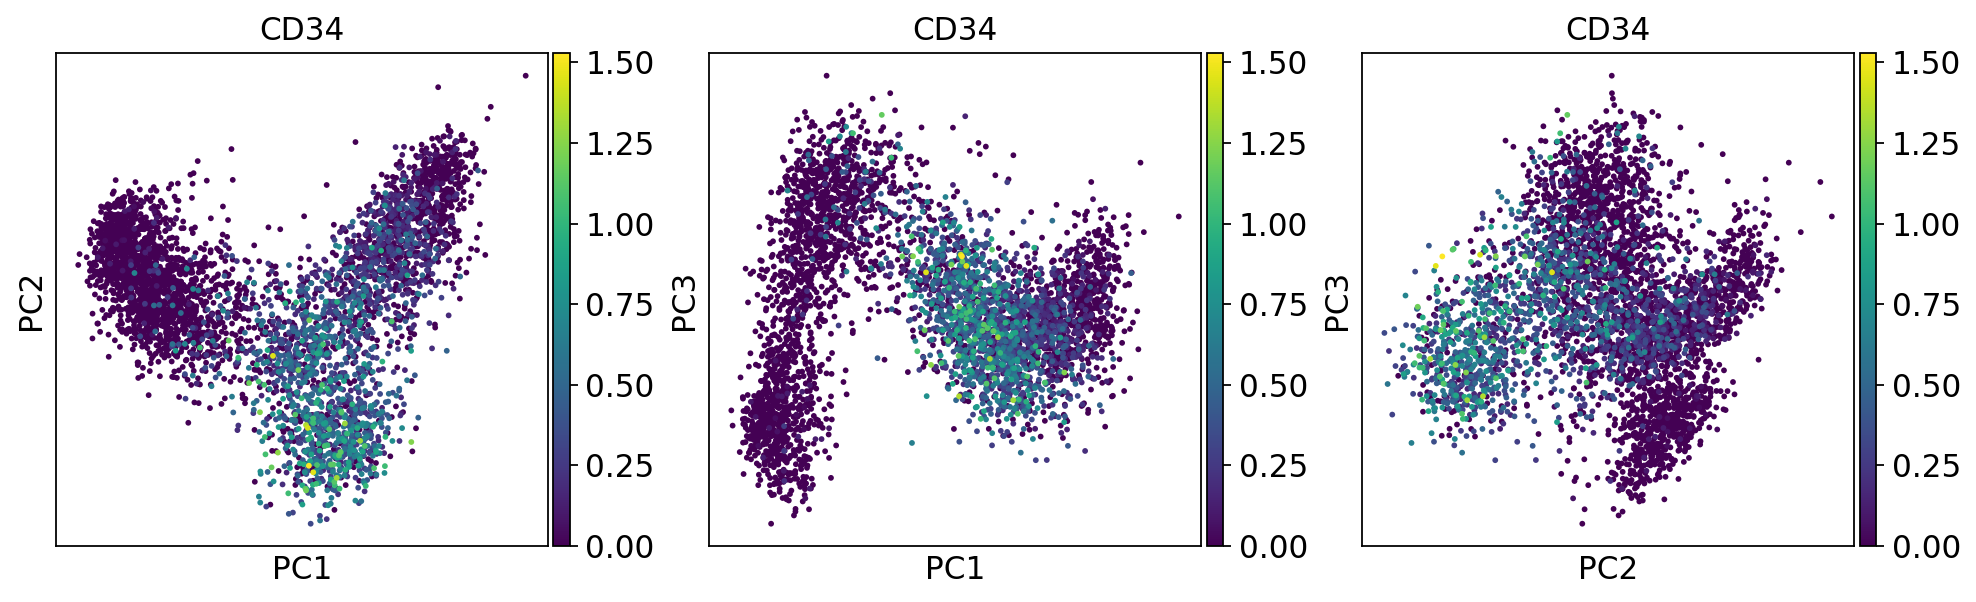

In [6]:
#Examination of PCA using all features available (14955 genes) 
sc.pp.pca(myeloid_adata, n_comps = 20,use_highly_variable=False)
sc.pl.pca(myeloid_adata,components=['1,2','1,3','2,3'],color='CD34') 

Next, we examine the overall result of a PCA with the consideration of feature selection (558 genes)

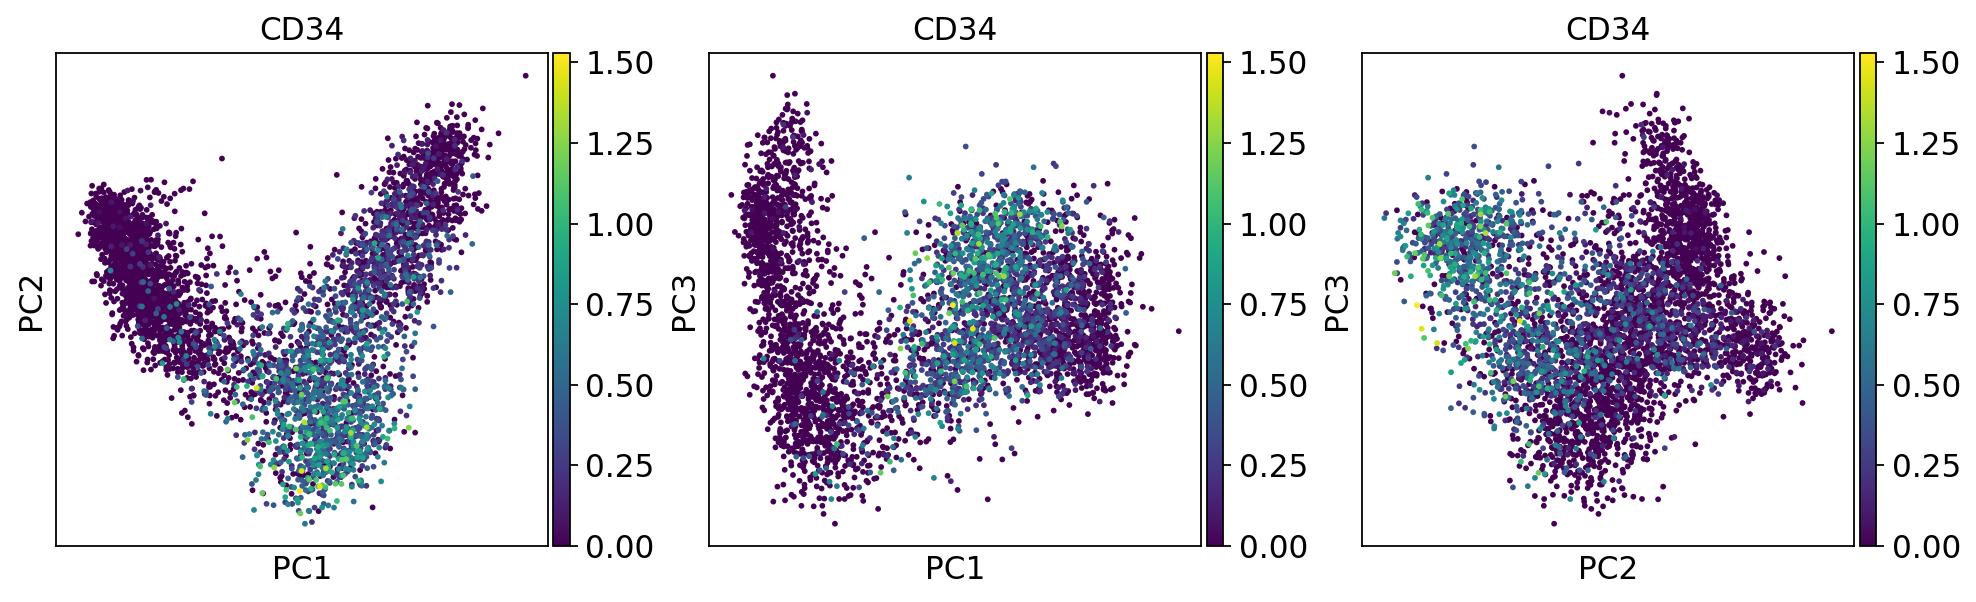

In [7]:
#Examination of PCA using all features available (558 genes) 
sc.pp.pca(myeloid_adata, n_comps = 20,use_highly_variable=True)
sc.pl.pca(myeloid_adata,components=['1,2','1,3','2,3'],color='CD34') 

In both cases, we observe a general conservation of structure relative to a CD34 overlay (representing more stem-like cell states). The difference is that we have extracted the most robust biological signal from approximately the top 4% of all captured genes. This drastically reduces noise and reduces the computational resources necessary to process these data.  

### Principal component subsetting

We need to further remove noise associated with single cell data sets. And we recommend preprocessing the data prior to applying p-Creode. If your data has already been preprocessed (ie. PCA or diffusion maps) to your satisfaction you can skip ahead to the Density section. Here, we will be processing the data using principal component analysis (PCA) and selecting a cutoff representing the most informative principal components. 

As we ran a PCA in the above section, we can now plot the explained variance for each principal component.

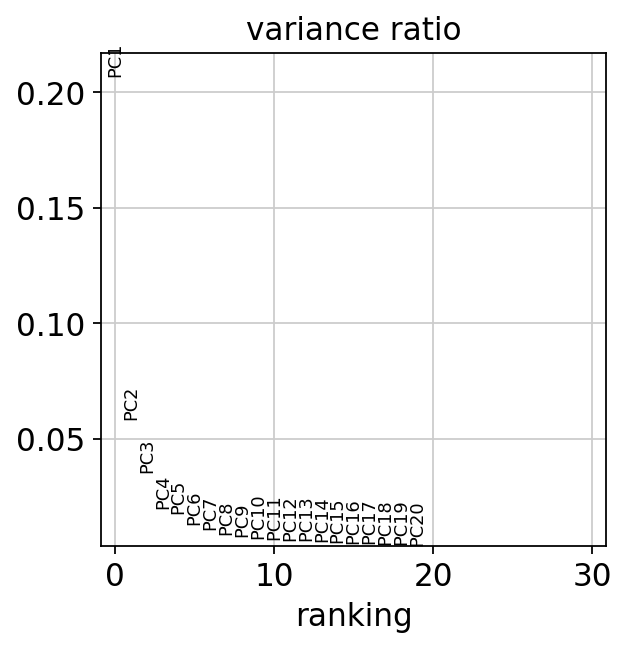

In [8]:
sc.pl.pca_variance_ratio(myeloid_adata) #note that the vast majority of the variance in the data is captured by the first 10 principal components or so

We can further visualize the components derived from our PCA using Scanpy's plotting module. The components parameter enables the quick visualization of several components in a pairwise manner.

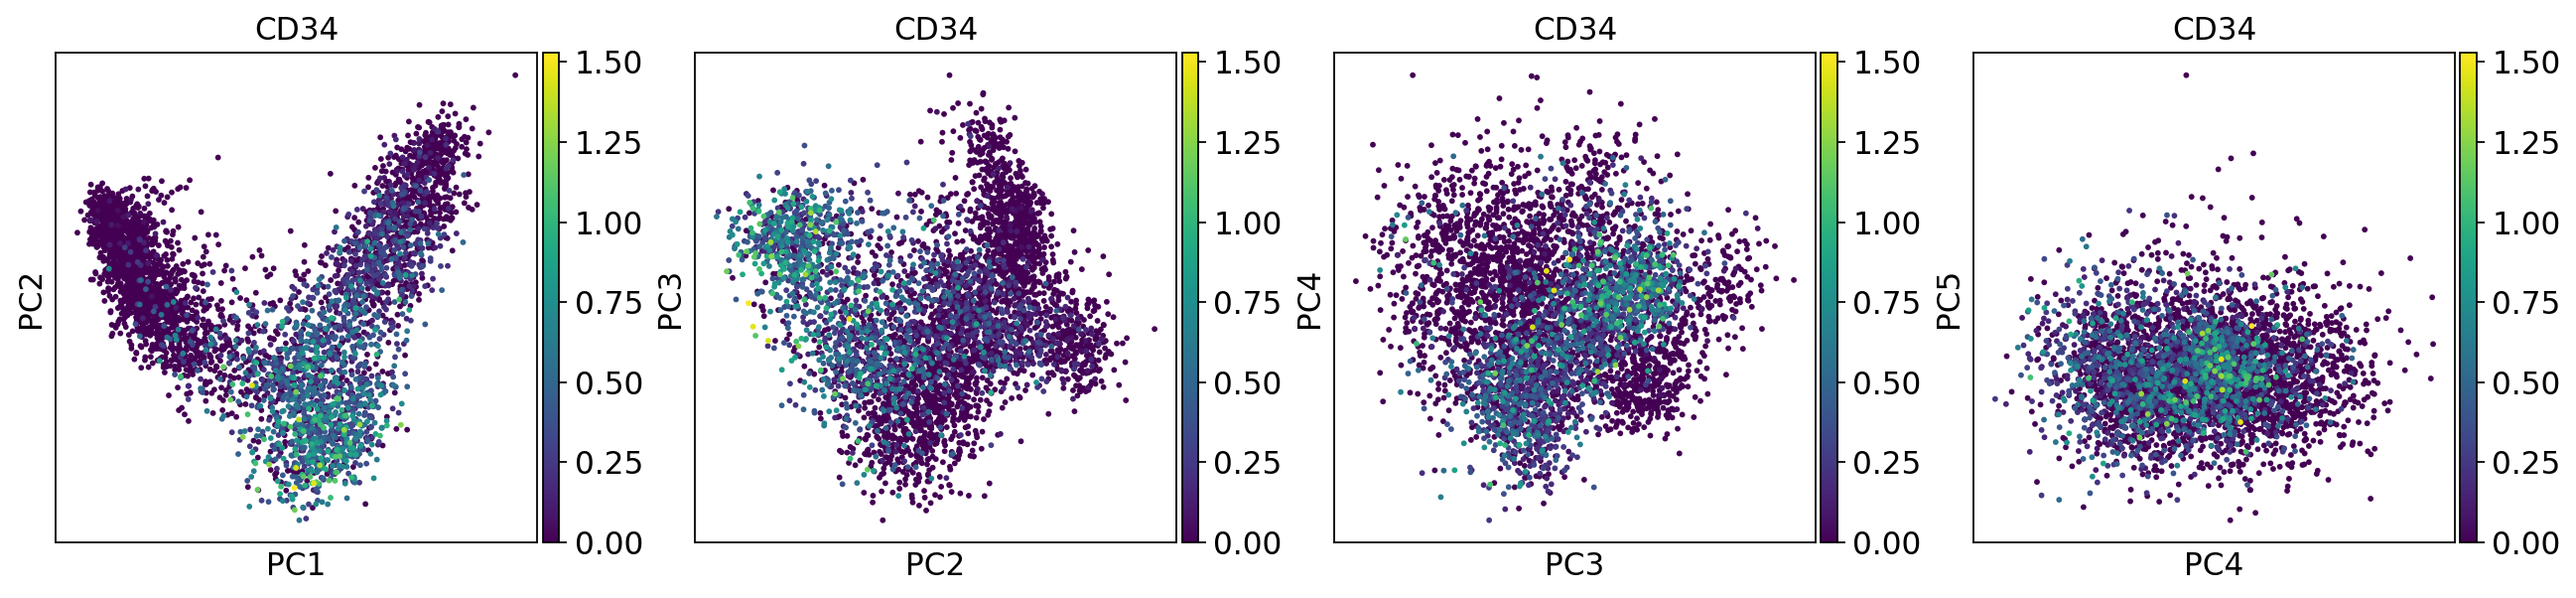

In [9]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3','3,4','4,5'],color='CD34') 

Judging from the plots above, there is little to no gain in structure of the data distribution beyond the PC3, evident by the lack of definition in plots containing PC4 and above. Therefore, there is likely little gain in using more than 3 principal components.

In [10]:
pca_reduced_data = myeloid_adata.obsm['X_pca'][:,:3] #Here we simply subset the myeloid_adata PCA observation matrix to its first 3 components using standard array subsetting conventions

The resulting variable, "pca_reduced_data", represents the coordinates of each cell, in three dimensions of PCA space. This is what we will pass to the density/downsampling sections of this analysis.

In [11]:
pca_reduced_data.shape

(4423, 3)

# Density Calculation

Now that the preprocessing has been performed, the density of each data point can be calculated. This process is started by calling the pcreode. Density class using the PCA processed data. The format of the data set for the Density class should be a numpy array. 

In [12]:
dens = pcreode.Density( pca_reduced_data )

To calculate the densities of the data points, the radius of inclusion must first be established. For each data point the density will be set by counting the number of other data points contained within the radius, where the radius is centered on the data point in question. Setting the radius is a very important step. The radius should not be so large that the range of densities is limited and not so small that noisy data points have the same density as non noisy data points. A good starting radius is can be generated by comparing the distance to the nearest neighbor for all data points. The nearest_neighbor_hist() function will return a hist of all nearest neighbors distances and a best guess for the radius.

best guess starting radius = 0.7445154786109924


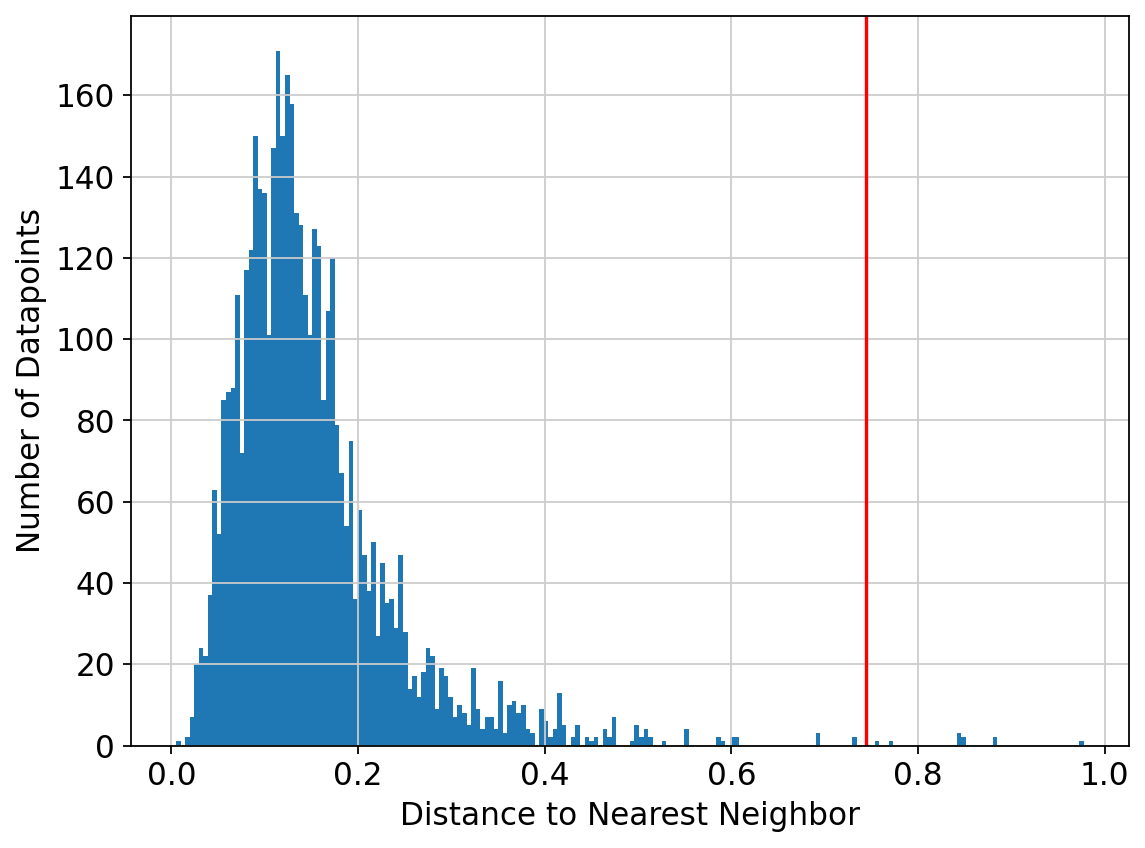

In [13]:
best_guess = dens.nearest_neighbor_hist()

While the best_guess from above is generally a good fit, this will not always be the case. Therefore, we will show how to manually set the radius value. To demonstrate this, we begin with a radius of ~0.4. We can calculate the density and plot a histogram of the values with the get_density() function. 

Note: With larger data sets this will take some time to calculate, so with a larger data set we recommend saving the density array so that the densities don't have to be recalculated. If the data set changes in anyway (different preprocessing routine, add/remove PCs, use a different arcsinh cofactor, etc) the density will need to be recalculated.

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


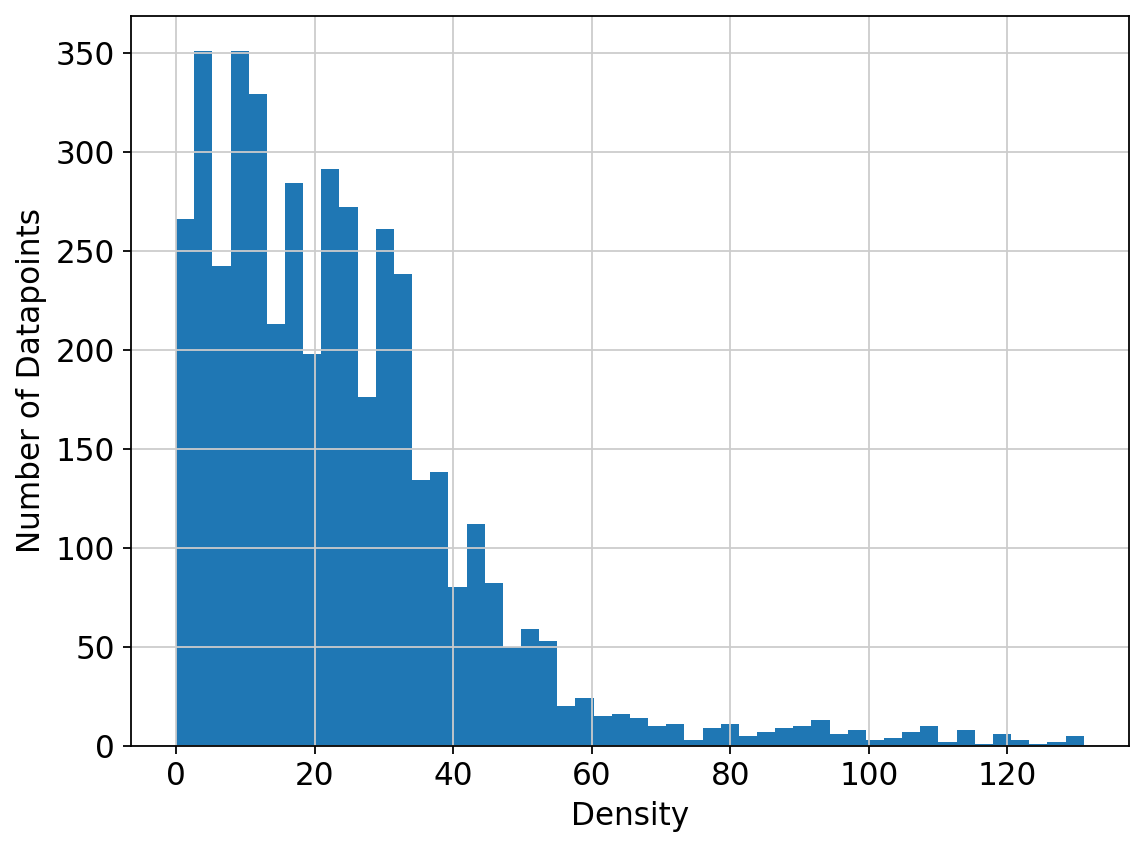

In [14]:
myeloid_adata.obs['Density'] = dens.get_density( radius=0.4) #set myeloid_adata 'Density' observation
dens.density_hist( n_bins=50)

Looking at the results for radius=0.4 the histogram shows that there are a large number of data points with a density of zero. This likely means that it will be hard to discriminate noisy data points from potentially rare cell types during down-sampling. In addition to the histogram of densities, one of the best ways to check radius fit is to look at the density values overlaid onto the PCA plots.

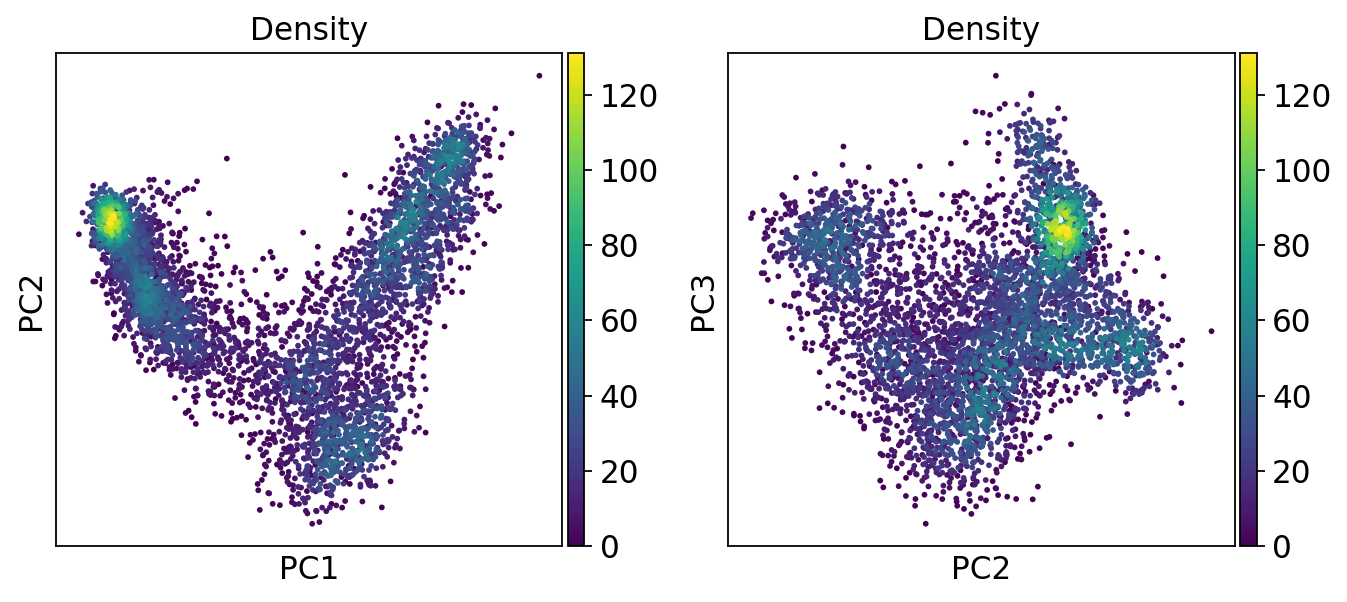

In [15]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density') #overlay each cell's Density value onto a three principal components

Radius at 0.4 appears to be too small of a radius, as density (yellow) is not observed in all areas of relevant data space. We now focus on increasing the size of the radius to see when we start to lose resolution.

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


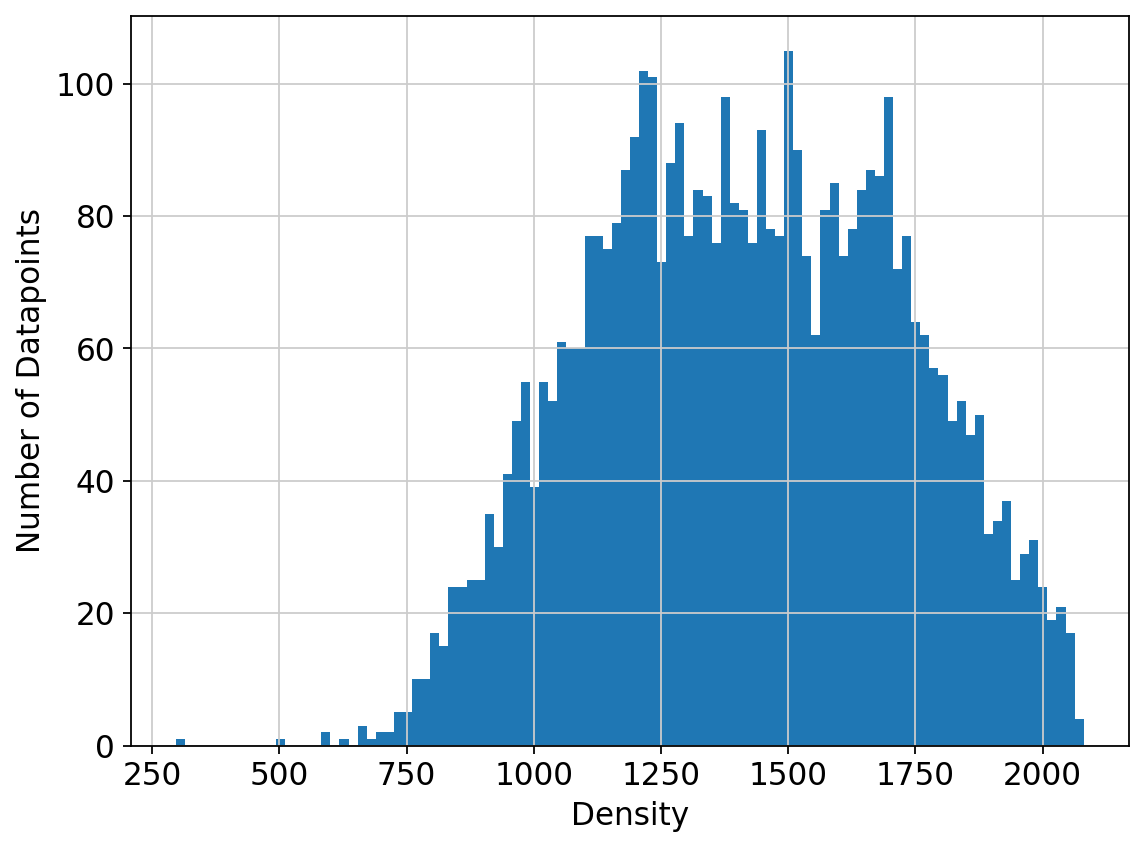

In [16]:
myeloid_adata.obs['Density'] = dens.get_density( radius=3) #set myeloid_adata 'Density' observation
dens.density_hist( n_bins=100)

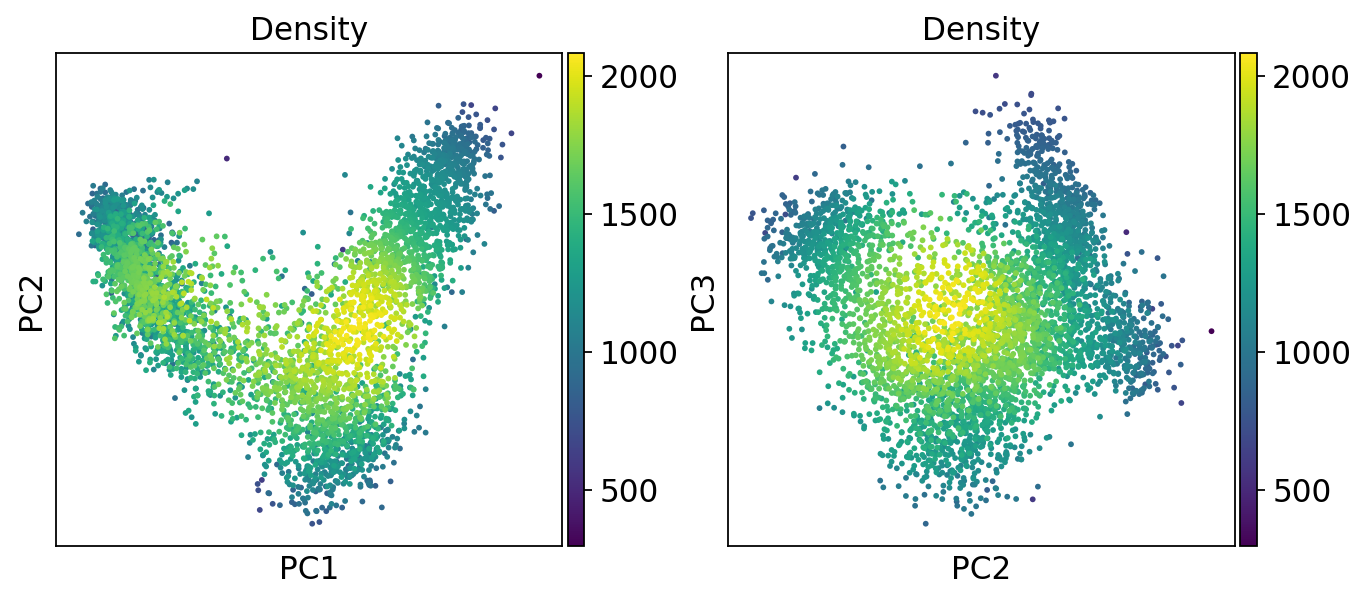

In [17]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components

At radius=3.0 the range of densities has increased as evident by the x-axis range of the histogram, but the PCA overlay shows that the majority of data points with large densities are located more centrally, likely meaning the increase in range of densities is due the location of the data point globally and therefore less informative on its local density. Since 0.4 is too small and 3.0 is too large, the density we are looking for is somewhere in between the two.

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


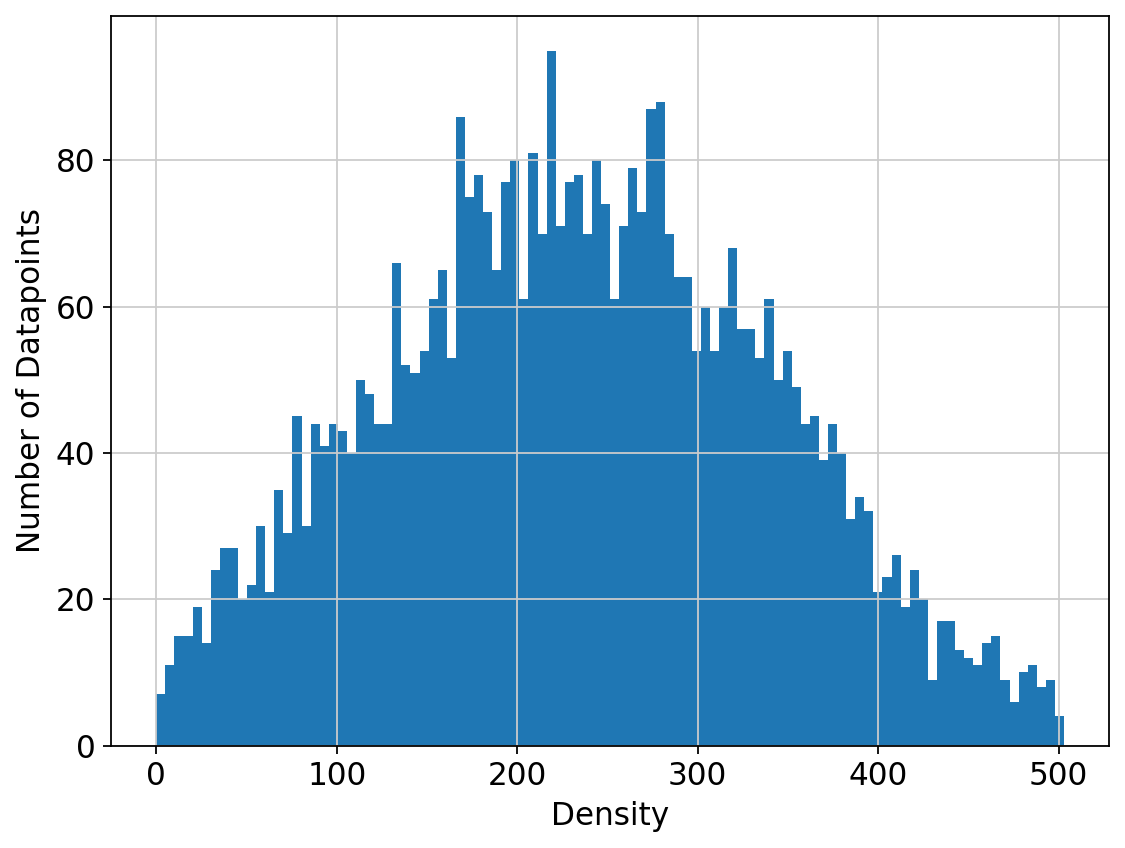

In [18]:
myeloid_adata.obs['Density'] = dens.get_density( radius=1) #set myeloid_adata 'Density' observation
dens.density_hist( n_bins=100)

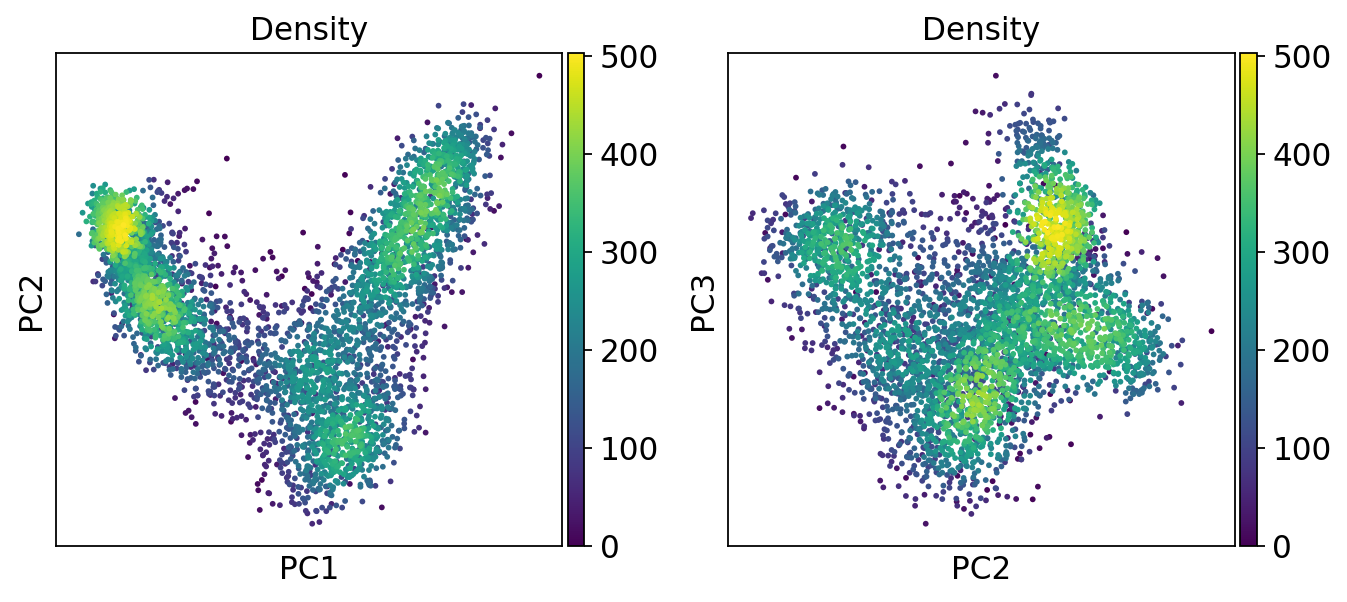

In [19]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components

At radius equal to 1.0 (very close to our best_guess), there is a good distribution of densities and with the PCA density overlay we can see local density in all areas of relevant data space (red/yellow distributed locally in cell populations, and not radially from the center). Being able to see different populations of cell types is a good indication that the radius size is set correctly.

If you are unsure about the radius setting, we advise you to run the full p-Creode algorithm over a range of radius values. It has been our experience that the radius fit value does not have to be set very exactly, and p-Creode tends to produce similar results over a range of values. 

# Setting down-sampling parameters

Now the radius is set (radius=1.0) the noise and target density parameters used for down-sampling the data can be set. The noise variable controls which data points will be removed and the target density is the desired density of output. The target density can be used to control the computational overhead by limiting the number of cells in the downsampled data set.

In [20]:
noise = 8 #noise cutoff based on density value
target = 20 #target downsampling proportion

Here, we perform a preliminary check of how density-based downsampling removes noise from PCA.

In [21]:
downed, downed_ind = pcreode_functions.down_sample( pca_reduced_data, myeloid_adata.obs['Density'], noise, target)

Number of data points in downsample = 2490


The best way to set the noise and target variables is by looking at the downsampled PCA. The noise variable should be raised until there are no longer any outlier data points visible. These variables represent the percentile of all densities. For instance, data points with densities in the lowest 8th percentile will not be included in the down sampled data set. Feel free to play around with these parameters to better understand their effects on the down-sampling routine. The target variable is used to cut down on high abundance cells in order to have a data cloud with relatively uniform distribution. A good rule of thumb is to set the target density until you have roughly 50% of the orginal data points in your downsampled dataset (in this instance, you started off with ~4500 and end up with ~2700). 

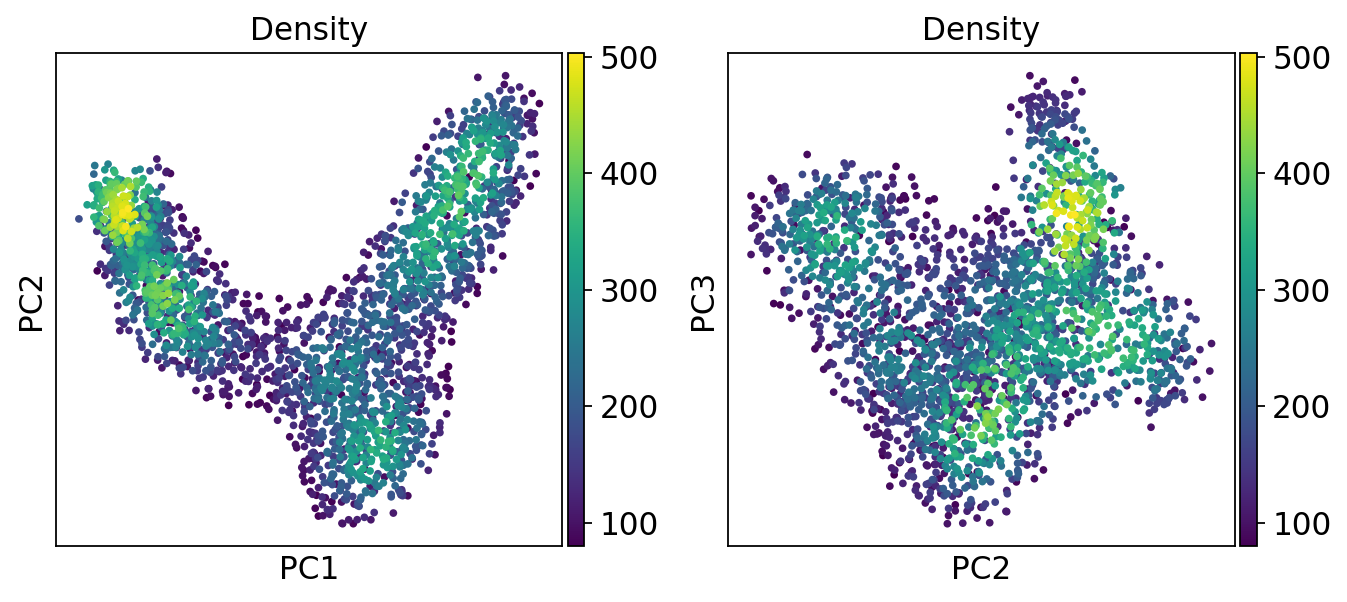

In [22]:
sc.pl.pca(myeloid_adata[downed_ind],components=['1,2','2,3'],color = 'Density')  #density downsampled

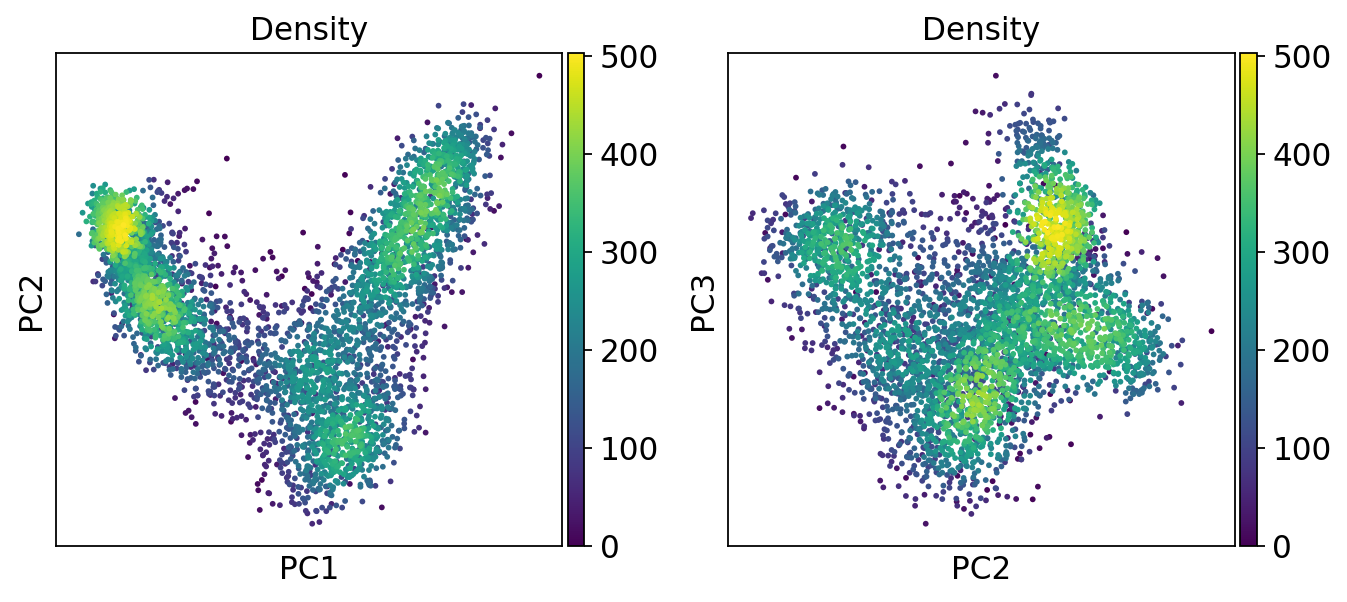

In [23]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density') #no downsampling

With the noise values at 8.0, we can see that almost all of the outliers have been removed in the down-sampled data set as compared to the original. Since there is a fine line between what is viewed as noise and what is viewed as a rare cell type, of the two parameters the noise value is the most critical. In this data set the target value is not critical given the already small of size of the original set, so we have set it 50.0 to better normalize the down-sampled density. With larger data sets, the target values should be lowered so that the computational cost is lowered to a manageable level. This level will vary computer to computer.

# Obtaining p-Creode graphs

Now that all the parameters have been set we can run the main p-Creode algorithm and produce a series of graphs. We suggest you run at least 100, but we will only run 10 here. A directory should be created to hold the graph outputs and the path to your new directory should be updated for the pCreode function call. (Again, change the directory to your settings here) PC users will have to use Windows directory formatting, do not omit the backslash "/" at the end.

Set output folder for p-Creode graphs

In [24]:
file_path = "/tmp/"

Run pcreode for n number of runs, will output to above directory

In [25]:
runs = 10

out_graph, out_ids = pcreode_functions.pCreode( data=np.array(pca_reduced_data), density=np.array(myeloid_adata.obs['Density']), noise=noise,
                                      target=target, file_path=file_path, num_runs=runs)

Performing 3 independent runs, may take some time
Number of data points in downsample = 2499
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 1
Number of data points in downsample = 2504
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 2
Number of data points in downsample = 2554
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 3


# p-Creode graph scoring

Finally we can score the graph outputs to find the most representative graph. The file path should be the same as above and the number of graphs (num_graphs) should be set to 10 or the number you want to score if you ran more or less than 10 graphs above. The data variable should be set to the same data set used in the pCreode function. The final output will be a ranking of graph IDs from first to worst based how respresentative p-Creode thinks they are of the data.

In [26]:
graph_ranks = pcreode.pCreode_Scoring( data=pca_reduced_data, file_path=file_path, num_graphs=runs)

scoring graph 1
scoring graph 2
Most representative graph IDs from first to worst [2 1 0]


# Graph plotting

Looking at the ranked graphs above (results will differ with each) we can select the best graph from the run, in my case the graph ID was graph 8. Plotting the graphs can be a little frustrating given igraph's plot function (We are currently working on better plotting function). The the plotting function will produce a random graph visualization with each plot unless we seed the random number generator (the representation will be different but the graph will not change). We can seed the generator with the seed variable within the plot_save_graph function. It will sometimes take a few tries to get a graph that is easy to read (more tries are generally needed with graphs containing more nodes). [Here](https://github.com/KenLauLab/pCreode/blob/master/notebooks/Elane.png) is an example of what your output graph should look like. See paper for explanation of results. 

In [27]:
gid = graph_ranks[0] # this will select the first graph ID in the ranking from above
print(gid)

2


To start analyzing the outputs from pcreode, we begin by initializing the Analysis class from pcreode. The gid is the graph run you are interested in viewing, in this sepecific case it is the most representive graph. The file_path, data, and denstiy arguments should be the same as was used to produce the graph. 

In [28]:
analysis = pcreode.Analysis( file_path=file_path, graph_id=gid, data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise)

To view the graph plots with different overlays the plot_save_graph function from the Analysis class is used. The seed variable will likely have to be sampled at different values. The overlay variable should be the analyte you are interested in visualizing on the graph. This argument comes from the orignal data set if preprocessing (PCA, etc) was used to prior to building the graphs. The file_out is the name of the .png file you would like to output into the file_path directory. upper_range is a normalization variable that will vary analyte to analyte and should be changed to maximize the node color range.   

In [29]:
seed=5656565656565656565656

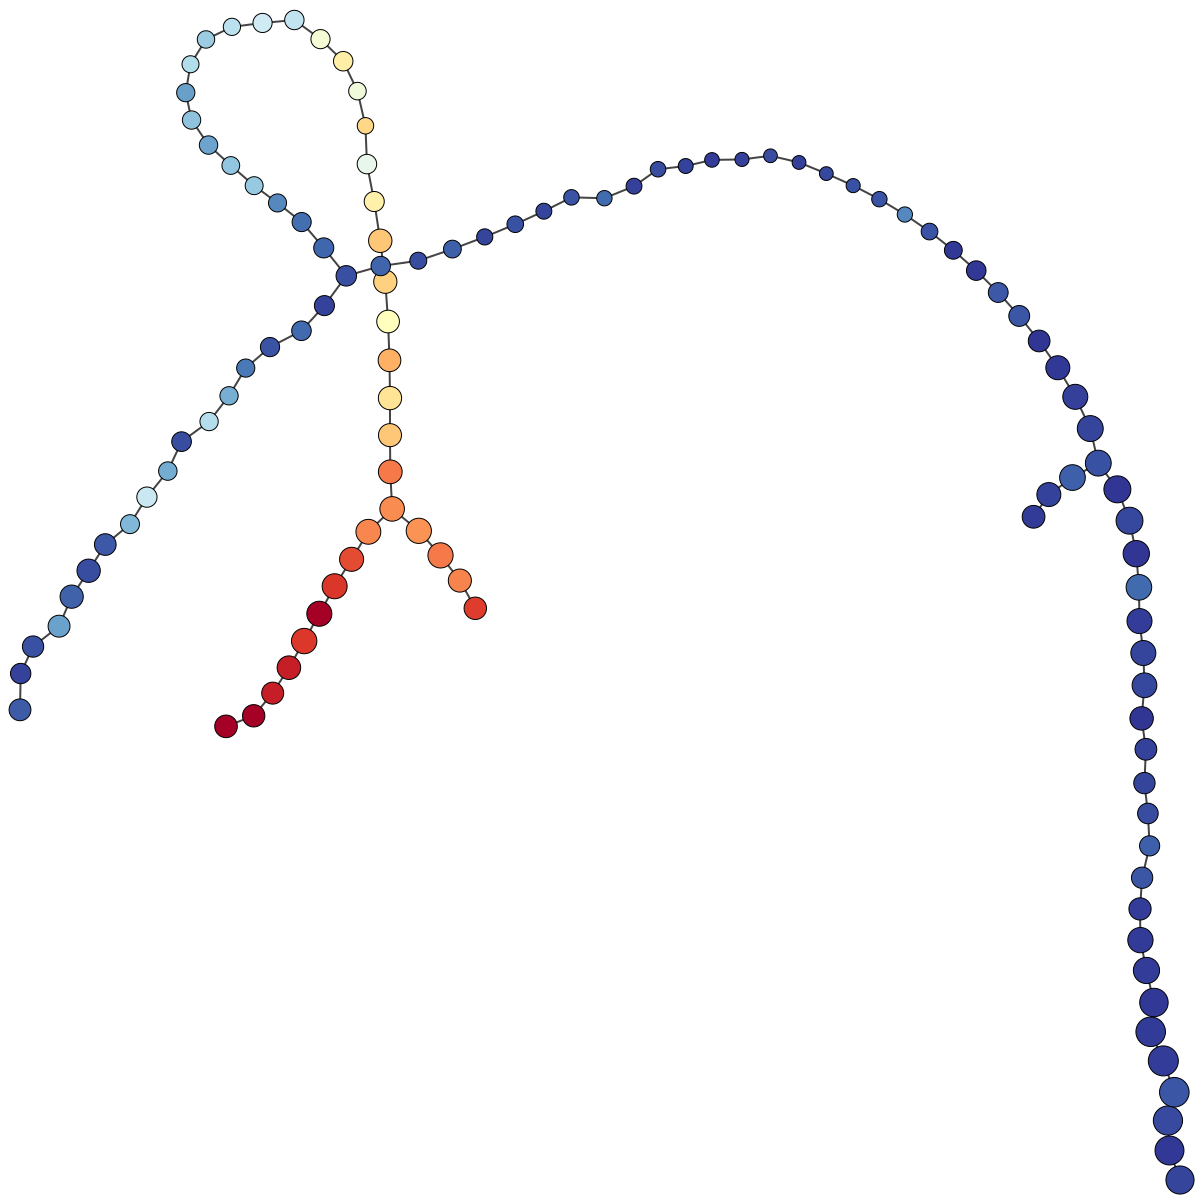

In [30]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('ELANE')), file_out='ELANE', upper_range=1.25)

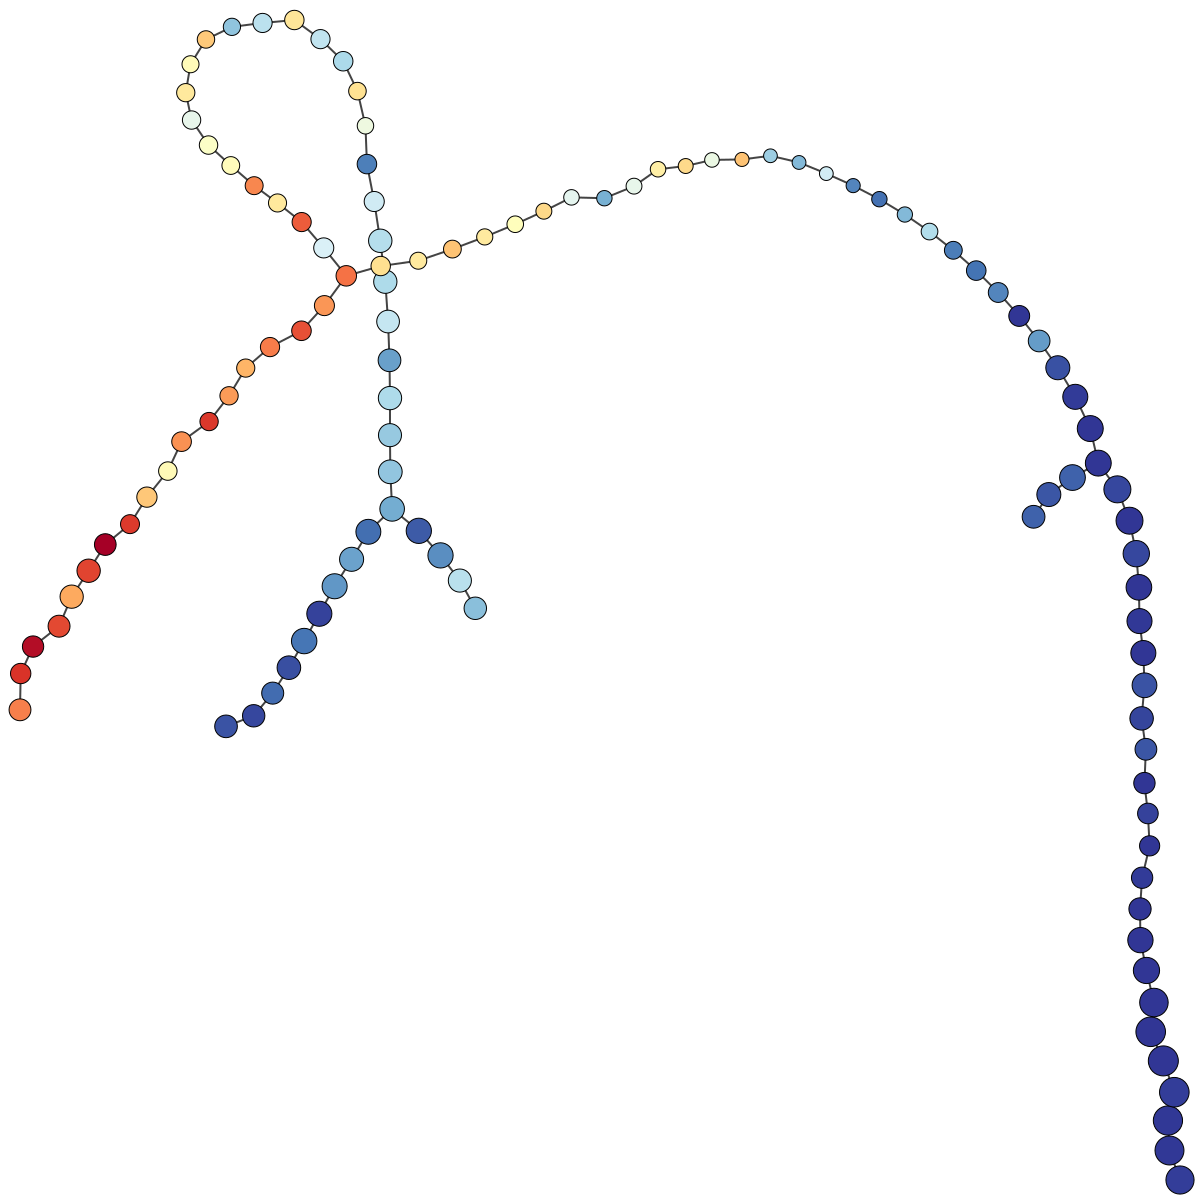

In [31]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('CD34')), file_out='CD34', upper_range=3)

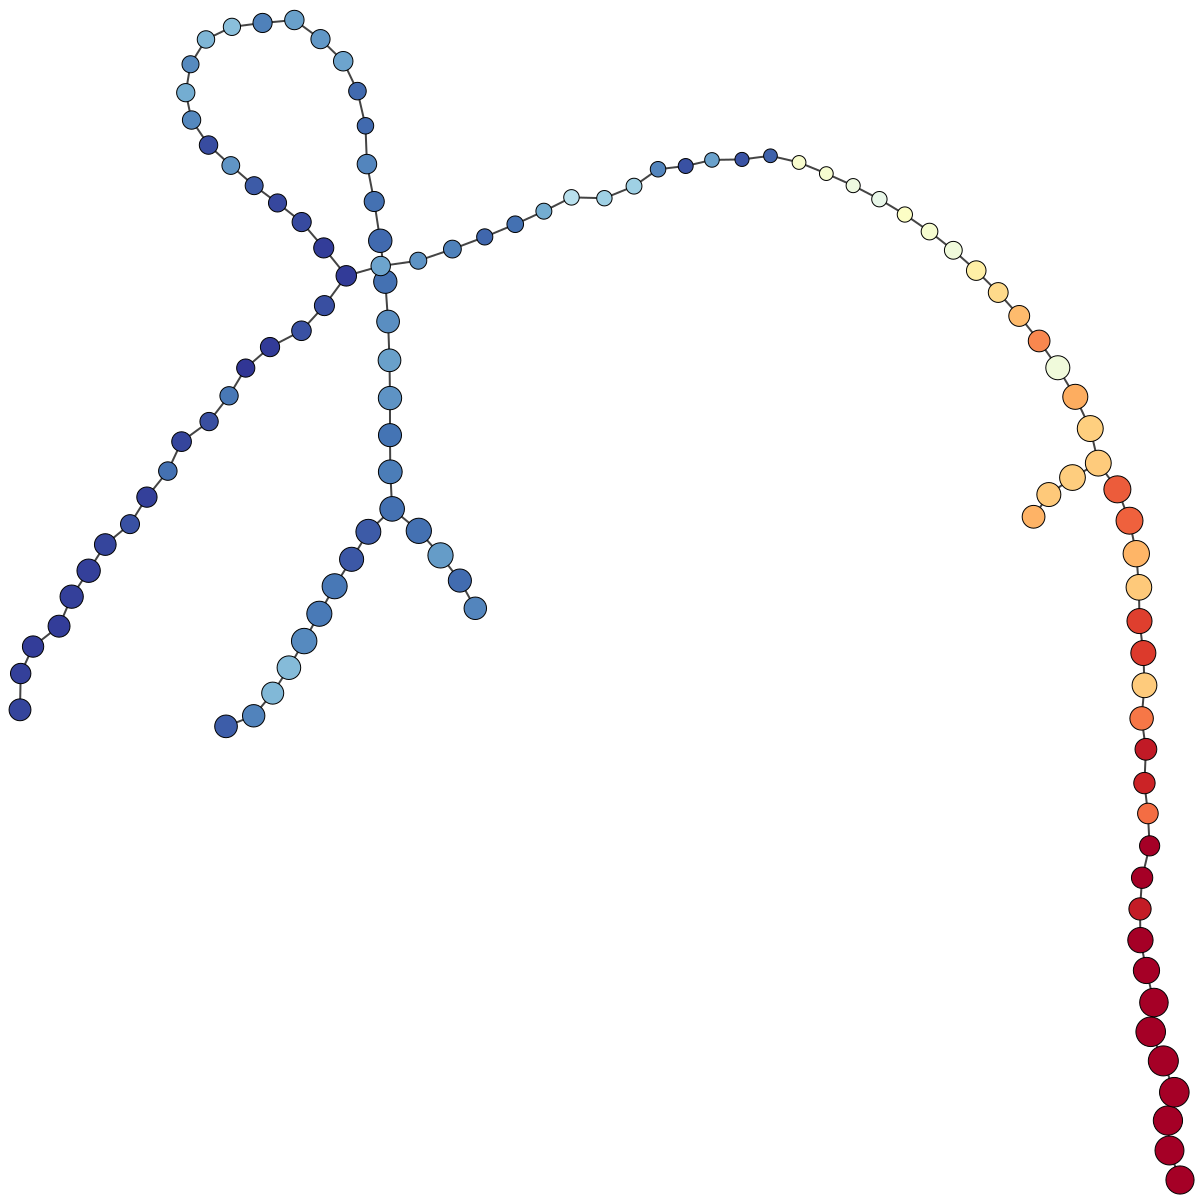

In [32]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('CAR2')), file_out='CAR2', upper_range=2)

### Qualitative data visualization

Qualitative data (i.e. time points, independent clustering ids, etc) can also be overlayed onto a graph. To demonstrate this feature K-means clustering of the data will be overlayed. Because igraph plotting is the bane of my existence, the figure legend is an independent graph and will not be included in the saved .png file in the output directory, but it can be easly saved by right clicking.

In [33]:
num_clusters = 3
clust_model = KMeans(n_clusters=num_clusters, random_state=5).fit( pca_reduced_data)
qual_data = clust_model.labels_
qual_data

array([0, 0, 1, ..., 0, 0, 0], dtype=int32)

In [34]:
str_qual_data = qual_data.astype( str)
str_qual_data

array(['0', '0', '1', ..., '0', '0', '0'], dtype='<U11')

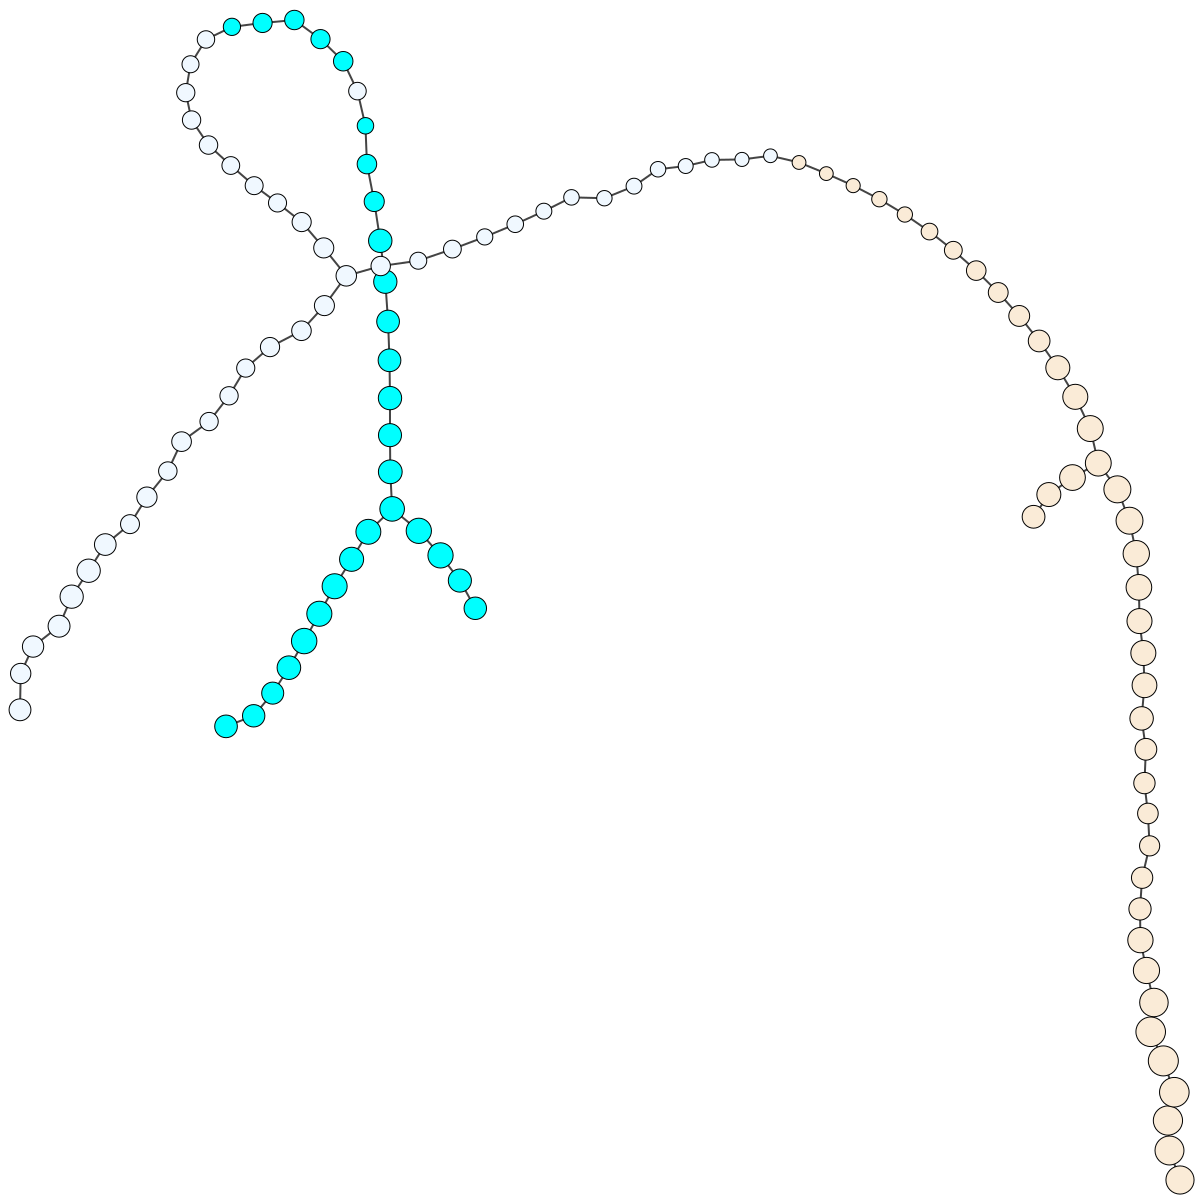

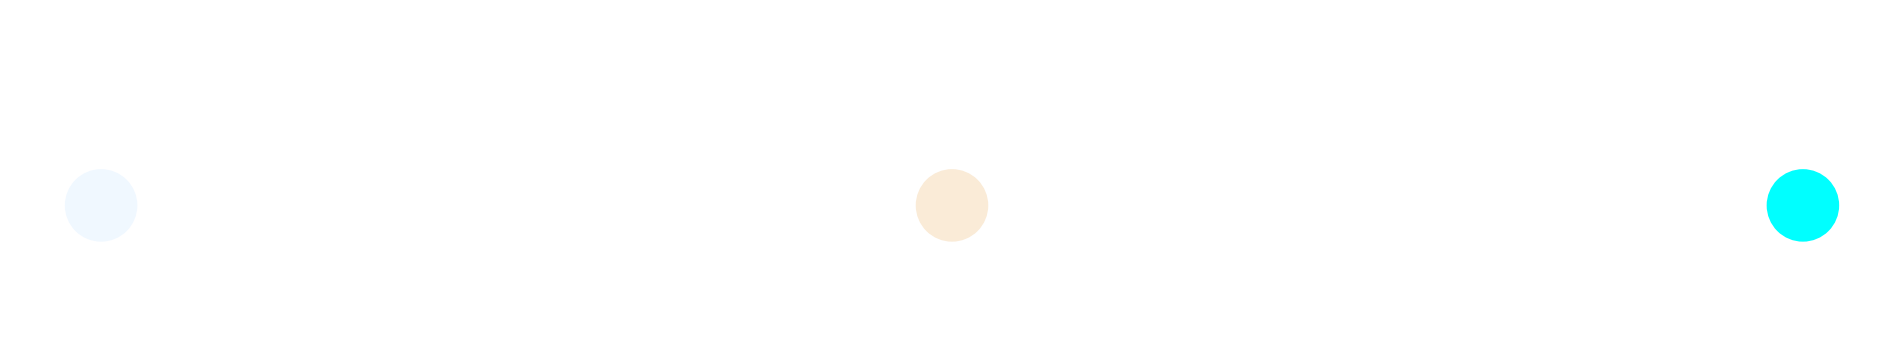

In [35]:
analysis.plot_save_qual_graph( seed=seed, overlay=str_qual_data, file_out='3_clusters_overlay')

To produce a labeled graph with node graph node ids, use code below; a more readable output will be in the output directory. 

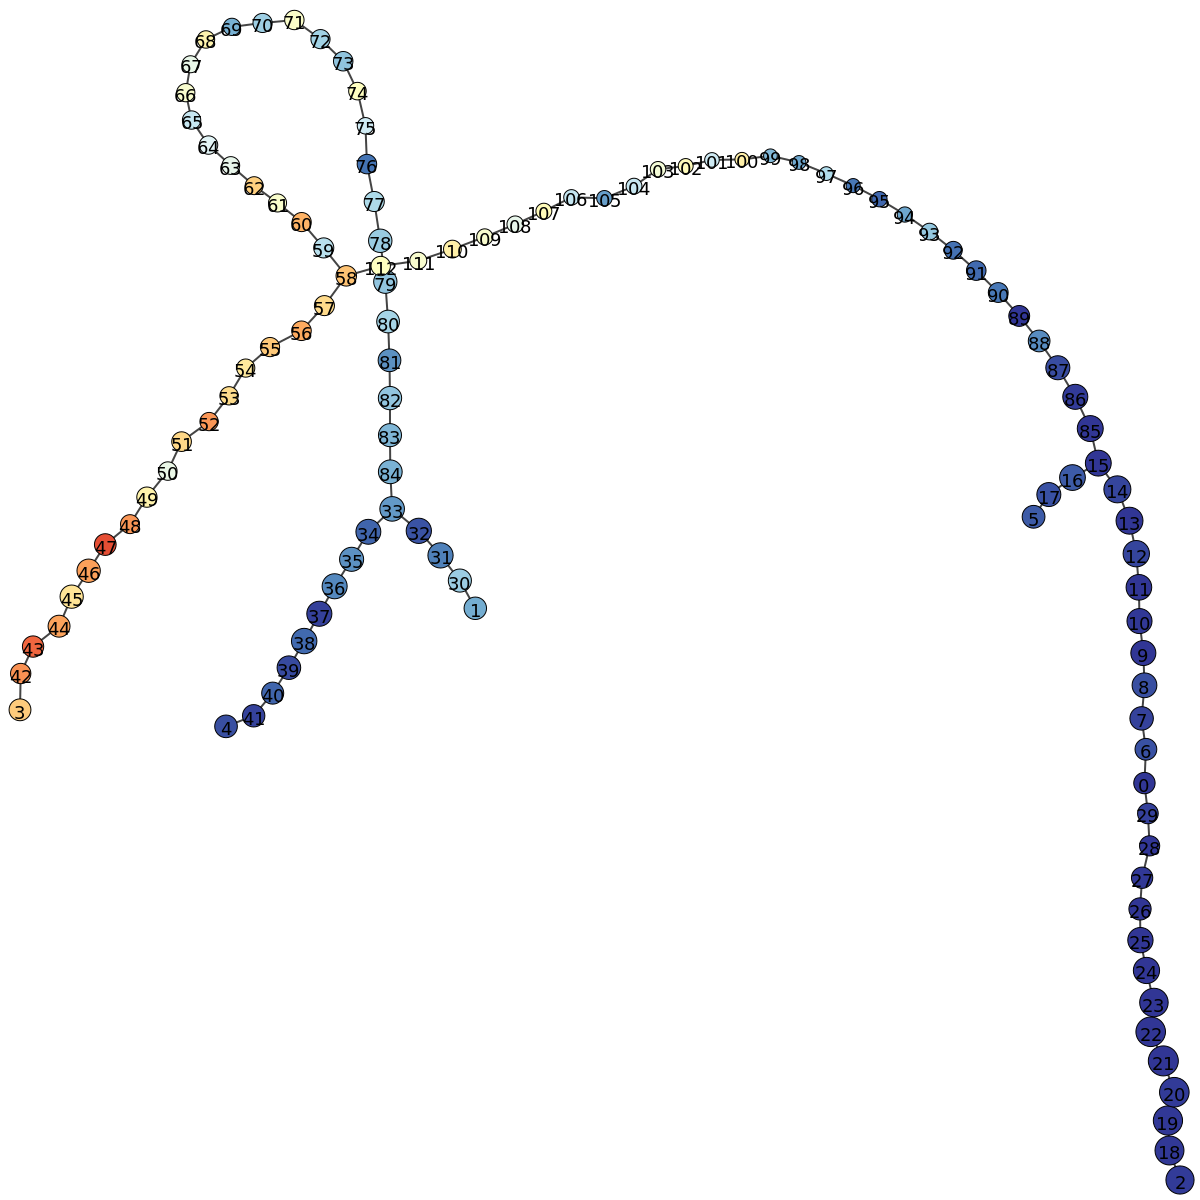

In [36]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('CD34')), file_out='CD34_with_ids', upper_range=2.5, node_label_size=18)

### Analyte dynamics

Analyte dynamics can be viewed using the function below. A "root" node will have to be supplied, all possible trajectories will be shown with the given overlay. Red vertical dotted lines indicate a branch point and the black dotted vertical lines the end of the trajectory. The solid black lines for each bar indicated the standard error for all the cells assigned to that node (cells are assigned to the node closest to them). The root id is best found using the id overlay on the graph plots, the png file in the output directory is likely more readable. 

/home/administrator/anaconda3/envs/pcreode/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


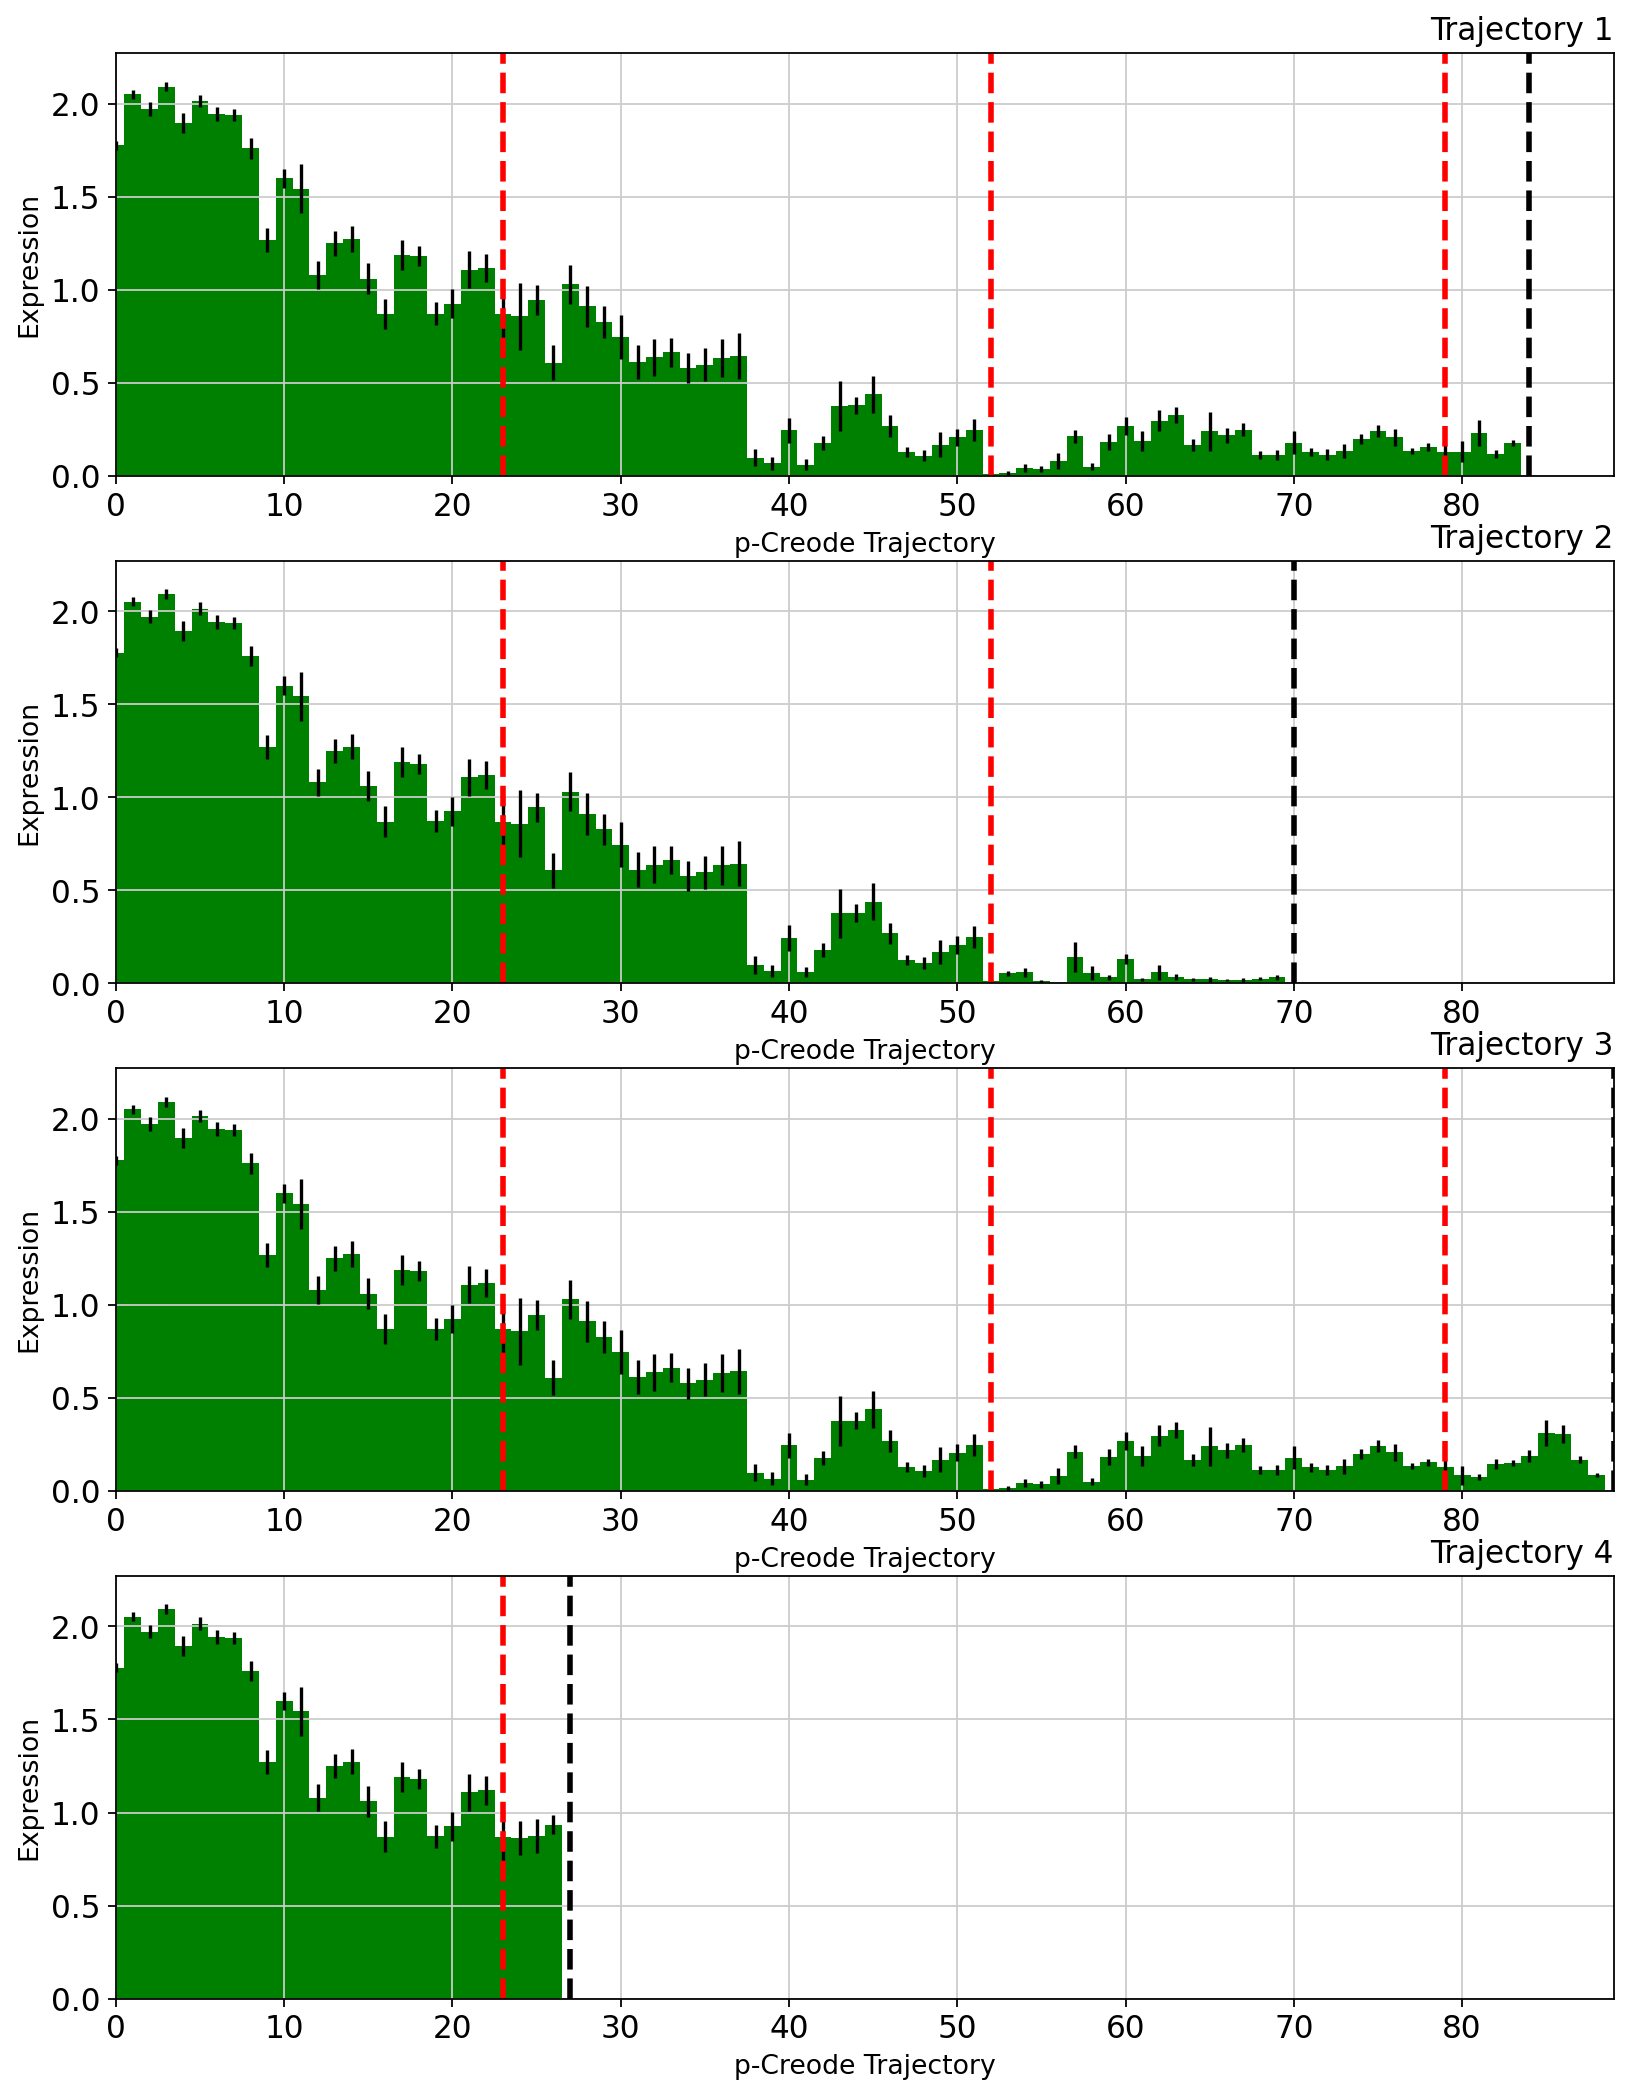

In [37]:
analysis.plot_analyte_dynamics( pd.Series(myeloid_adata.obs_vector('CAR2')), 2)

/home/administrator/anaconda3/envs/pcreode/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


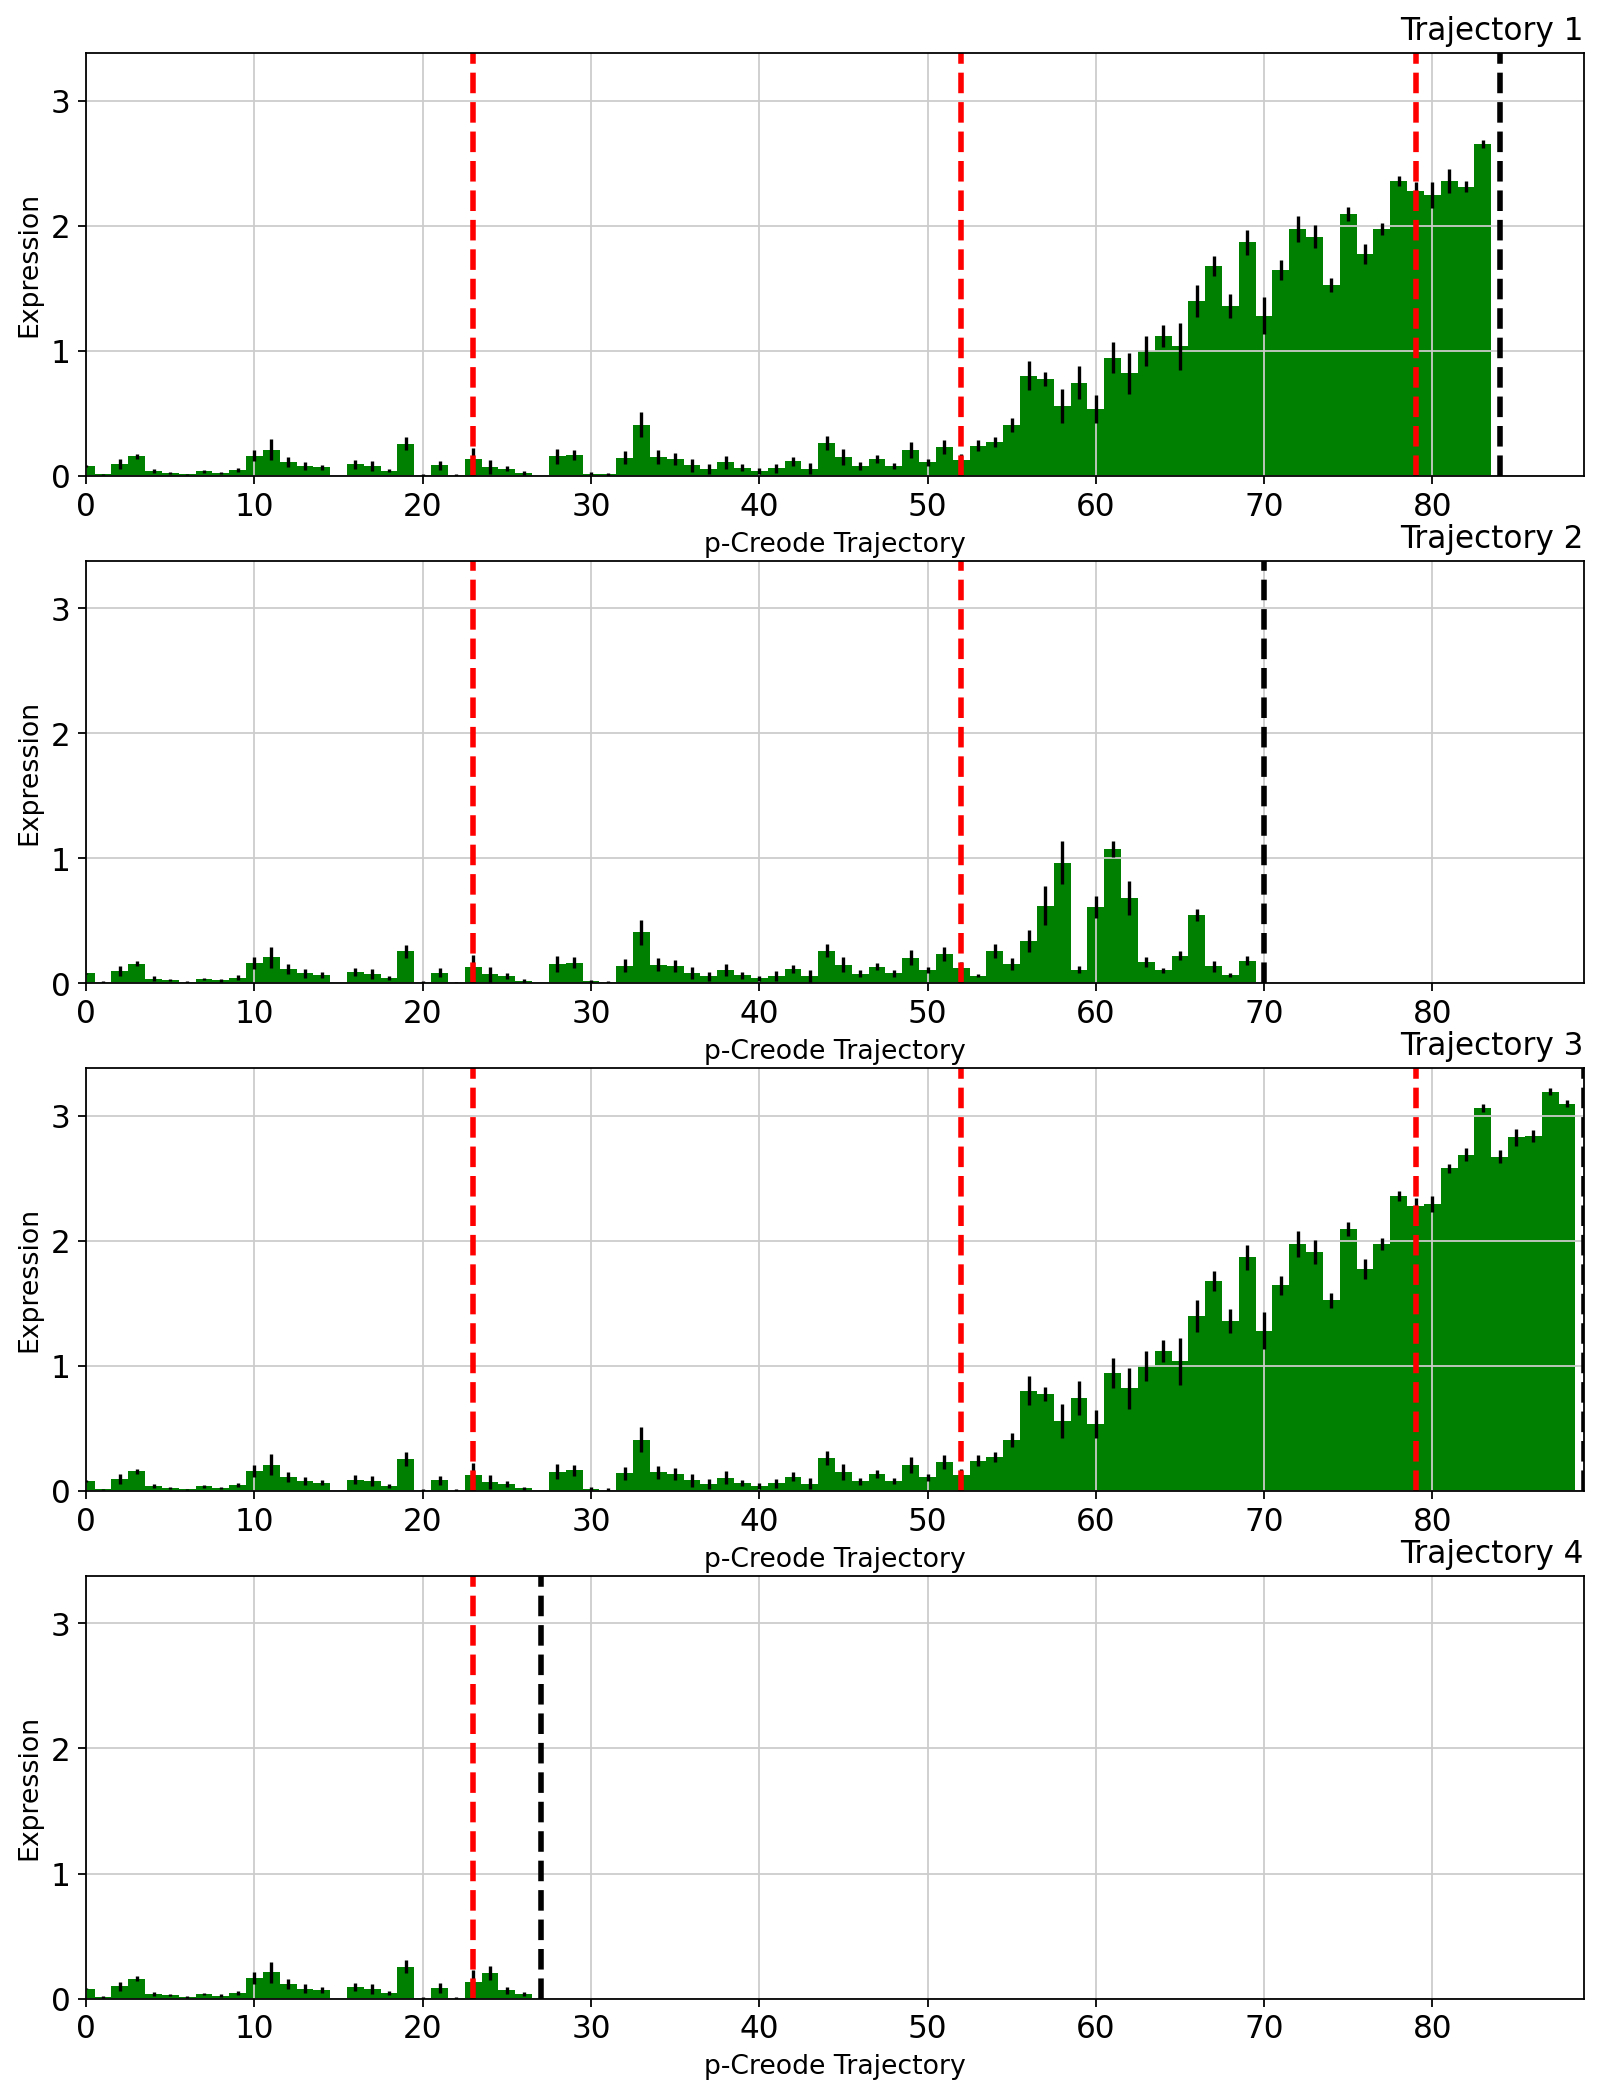

In [38]:
analysis.plot_analyte_dynamics( pd.Series(myeloid_adata.obs_vector('ELANE')), 2)

To produce a csv files for export containing all analyte dynamics for each trajectory use the function call below. A csv file for each trajectory will be created, trajectory labels are the same as above. To produce the graph overlays and trajectory analysis all of the cells that are over the noise threshold are binned into one of the selected graph nodes. This function call will also produce a file containing the id to which each cell was binned.  

In [39]:
analysis.get_complete_analyte_gene_trajectories( pd.DataFrame(myeloid_adata.X), 0, file_out='Myeloid')

/home/administrator/anaconda3/envs/pcreode/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


If you would like to escape the limitations of python graph plotting you can export an weighted adjacency matrix, which then can be up loaded into more capable graphing softwares like Cytoscape.

In [40]:
w_adj = pcreode.return_weighted_adj( pca_reduced_data, file_path, gid)
w_adj

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.27307734,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.27307734, 0.        ,
        0.31903988],
       [0.        , 0.        , 0.        , ..., 0.        , 0.31903988,
        0.        ]])